# Session 3 - analysing cosmological simulations

In the previous session we ran our first cosmological simulation and began to do some basic analysis. One limitation of the simulation we ran is the relatively small box size and low resolution. To remedy this and to further explore the use, and limitations, of these simulations we have preran 4 simulation volumes to be used in this session. These are locate here `blah`, and have the following properties (the cosmology is the same as session 2):

 - L100N256_DMONLY, the fiducial run. Box size of $L=100 h^{-1}$Mpc with $256^3$ collisionless particles of mass $m_p = 5.23 \times 10^9 h^{-1} M_{\odot}$. Large volume.
 - L025N256_DMONLY. $L=25 h^{-1}$Mpc with $256^3$ collisionless particles of mass $m_p = 8.17 \times 10^7 h^{-1} M_{\odot}$. High resolution.
 - L025N064_DMONLY. The same simulation ran in session 2.
 - L100N256_HYDRO. This simulation no longer assumes all matter is in the form of collisionless DM. Instead the simulation starts with both gas and DM, with the formation of stars and black holes as structures grow and collapse. The baryon and galaxy formation model uses the [EAGLE](https://ui.adsabs.harvard.edu/abs/2014arXiv1407.7040S/abstract) model. (***Note: this simulation has not been calibrated for this mass resolution. As such, many galaxy properties will not match observed scaling relations. This simulation should therefore only be used to study the qualitative effect of baryons.***)
 
One key difference between these simulations and the one run in session 2 is that they have been run with the [VELOCIraptor](https://velociraptor-stf.readthedocs.io/en/latest/) halo finder. The outputs of the simulation include the snapshots, the power spectra, and a halo catalogue where structures have been identified into individual haloes using the Velociraptor algorithm.

## Instructions

This session is much more freeform than the previous two with no linear set of instructions. The plan is that you pick a statistic/property of interest from the following four (or feel free to think of your own):

- [Power spectrum](#Power_spec)
- [Galaxy clustering](#gal_clust)
- [Halo mass function](#halo_mass)
- [Density profiles](#dens_prof)

There is then a section for each of these statistics that shows how to process the simulation data to calculate it using the L100N256_DMONlY $z=0$ data. You can then use the 4 simulations to further explore these statistics and start to perform some analysis and research. Some common avenues of exploration are:

- Look at the redshift evolution?
- What is the effect of box size/resolution?
- What is the effect of baryons?

There are also a few suggestions specific to each section (see the relevant section).

We'll start by loading some standard libraries, define the cosmology we have run, and define a useful function to read the VELOCIraptor halo catalogues.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import swiftsimio as sw
import glob
import h5py as h5

#define cosmology
h=0.67321
Omega_m = 0.3158
Omega_l = 0.6842
Omega_b = 0.0494
n_s = 0.9661
A_s = 2.1488 * 10**(-9)
sigma_8 = 0.8102

#function to read volciraptor halo catalogues
def veloc_reader(loc,stat):
    #####################
    # - loc: the location of the file on disk
    # - stat: the name of the statistic to load
    #####################
    
    #get all files
    files = glob.glob(loc+'*')
    
    data = np.array(h5.File(files[0],'r')[stat])
    for i in range(len(files)-1):
        data = np.append(data,np.array(h5.File(files[i+1],'r')[stat]),axis=0)
        
    return(data)

<a id='Power_spec'></a>

## Power spectrum

A common statistic used to describe the large scale structure of the universe is the power spectrum. $P(k)$ is computed from the fourier transform of the density field (see Session 2 or more details). `swift` already has the functionality to calculate $P(k)$ on the fly, which we have done for these simulations. The power spectrum can be found in the `*/power_spectra/*` folder. These are simple text files so can easily be read. 

Formally, we would write the power spectrum as

$P(k) = <|\tilde{\delta} (\vec{k})|^2>$

Where $\tilde{\delta} (\vec{k})$ is the fourier transform of the overdensity field $\delta (\vec{x})$, and the triangular brackets denote taking the average over the given $k$ scale (where $k^2 = k^2_x+k^2_y+k^2_z$).

It is useful to compare the power spectrum measured in the simulations to that predicted by linear perturbation theory. This is commonly referred to as the linear power spectrum. It can be shown that when the density fluctuations are small (i.e. $\delta << 1$) they grow scale independently, such that their evolution can be written separably. Hence the linear power spectrum can be written as,

$ P_{lin}(k,z) = D^2(z) P_{lin}(k,z=0) $. Where $D(z)$ is the linear growth factor (normalised to unity today).

In the code below we use `camb` to generate the linear power spectra for the cosmology we've simulated, and compare to the measured $P(k)$ from the simulations. Here are a few ideas of what to explore:
- Study the redshift evolution. How do the k-modes that are close to the linear approximation vary?
- Study the effect of baryons and feedback. How does $P(k)$ change between the DMONLY and HYDRO run?
- Study the effect of box size and resolution. WHich modes are robustly measured in each DMONLY simulation?

<a id='gal_clust'></a>

Text(0, 0.5, '$P_{sim}/P_{lin}$')

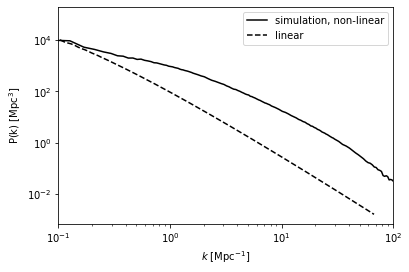

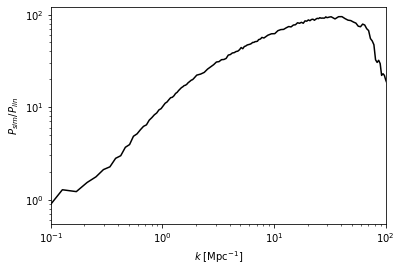

In [2]:
import camb
from camb import model, initialpower

#set up camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=(Omega_m-Omega_b)*h**2, mnu=0.0, omk=0.0, tau=0.06) #no netrinos, and flat. To match the simulation.
pars.InitPower.set_params(As=A_s, ns=n_s)
pars.set_matter_power(redshifts=[0.0], kmax=100.0) #change this line for different redshifts
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
k, z, pk_lin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=100, npoints = 200)
#convert camb outputs to h free units
k*=h; pk_lin/=h**3

#load simulation power spectrum
pk=np.loadtxt('../simulations/L100N256_DMONLY/power_spectra/power_matter_%04d.txt'%3)

#plot the linear and non-linear power spectra
plt.figure()
plt.plot(pk[:,1],pk[:,2],'k-',label='simulation, non-linear')
plt.plot(k,pk_lin[0,:],'k--',label='linear')
plt.xlim(10**-1,10**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$ [Mpc$^{-1}$]')
plt.ylabel('P(k) [Mpc$^3$]')
plt.legend()

plt.figure()
plt.plot(pk[:,1],pk[:,2]/np.interp(pk[:,1],k,pk_lin[0,:]),'k-')
plt.xlim(10**-1,10**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k$ [Mpc$^{-1}$]')
plt.ylabel('$P_{sim}/P_{lin}$')

## Galaxy clustering

We cannot directly observe the full distribution of matter in our universe. Instead, the most common tracer of the underlying structure are galaxies. With modern large galaxy surveys (SDSS, DES(I), etc) we can use the distribution of galaxies to probe the underlying distribution of matter. In our current understanding each galaxy is hosted by a dark matter halo, as such we can use the distribution of DM haloes in a DM only simulation to model the distribution of galaxies.

It is common to describe the clustering of galaxies through the autocorrelation function. For a distribution of points (i.e. galaxies) we can count the number of pairs that can be formed within a given radius, and compare this to a random distribution. This is called the 2-point correlation function, and often abbreviated to ‘the clustering’. It is standard to define the clustering, $\xi(r)$, as

$\xi (r) = \frac{< D, D> - 2 < D, R >}{<R,R>} +1$.

Where $D$ is the distribution of points with the signal we want to measure (i.e. the galaxies) and $R$ the random distribution of the same number of points. Here the triangular brackets denote counting the number of pairs that can be formed between the two distributions. Here $\xi=0$ means there is no clustering, and is consistent with a random distribution, while $xi>0$ means that the points are clustered and tend to lie together with the magnitude of $\xi$ describing how strong the clustering is.

In the below code we first load in the halo catalogue, particularly the positions of the DM haloes. We then define a function to calculate the clustering from a distribution of points. This uses a K-D tree to speed up the computation of pair counting, and also deals with the periodic boundary conditions. We then plot the distribution of haloes, that can visibly be seen to cluster, followed by $\xi(r)$. Here's a few ideas of thing to explore:

- How does the clustering of haloes compare to the clustering of all matter? (i.e. compare the clustering of the haloes and the individual DM particles).
- How does the clustering depend on halo mass, which massed haloes are the most or least clustered?
- Explore the redshift evolution.
- Explore the effect of box size and resolution.
- In the hydro run how does the clustering depend on the properties of the galaxies. What if the sample is split into 'blue' (star forming) and 'red (quiescent) galaxies?

Could not find gas gamma, assuming 5./3.


Text(0, 0.5, '$\\xi (r)$')

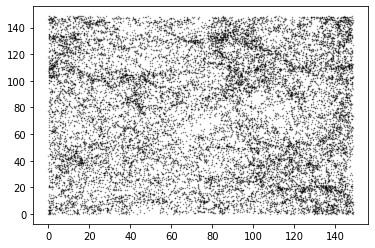

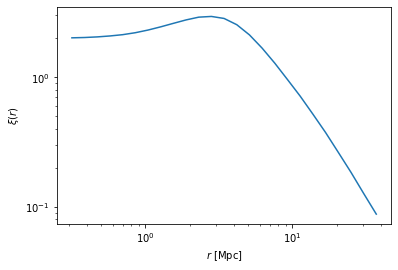

In [3]:
from scipy import spatial
file_loc = '../simulations/L100N256_DMONLY/output/halo_catalogue/haloes_0003.VELOCIraptor.properties'

#get some information about the simulation (doesn't matter which snapshot for this section)
data = sw.load("../simulations/L100N256_DMONLY/output/snapshots/snap_0000.hdf5") #read first snapshot
L = data.metadata.boxsize[0] #get boxsize

#get substructure information
halo_type = veloc_reader(file_loc,'Structuretype')
cut = halo_type==10 #select centrals

#halo mass
M_200m = veloc_reader(file_loc,'Mass_200mean')

#get halo positions
x_pos = veloc_reader(file_loc,'Xcminpot')
y_pos = veloc_reader(file_loc,'Ycminpot')
z_pos = veloc_reader(file_loc,'Zcminpot')

pos = np.empty((len(x_pos),3))
pos[:,0] = x_pos; pos[:,1] = y_pos; pos[:,2] = z_pos;

#cut to only consider central haloes
pos=pos[cut]


#function to calculate clustering of a group of points
def clustering(pos,r,box):
    #create random distribution
    pos_random = np.random.rand(pos.shape[0],pos.shape[1])*box
    
    #create kd_trees to speed up neighbour search
    kd_signal = spatial.KDTree(pos,boxsize=box)
    kd_random = spatial.KDTree(pos_random,boxsize=box)
    
    #count number of neighbours that can be formed, and clucalte clustering
    clust = (kd_signal.count_neighbors(kd_signal,r) - 2*kd_signal.count_neighbors(kd_random,r)) \
            / kd_random.count_neighbors(kd_random,r) +1
        
    return(clust)

r = np.logspace(-0.5,np.log10(L/4),25)
clust = clustering(pos, r, L)

plt.figure()
plt.plot(pos[:,0],pos[:,1],'k.',markersize=1.,alpha=0.5)

plt.figure()
plt.plot(r, clust)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r$ [Mpc]')
plt.ylabel('$\\xi (r)$')

<a id='halo_mass'></a>

## Halo mass function

Through gravity the initially small density fluctuations collapse into virialised, roughly spherical objects called DM haloes. It is these structures that host the galaxies in our own Universe. One of the most basic properties of DM haloes is their mass$^1$.

In these simulations we have already ran a halo finder, [VELOCIraptor](https://velociraptor-stf.readthedocs.io/en/latest/), that first identifies the haloes in the simulations and calculates a number of common statistics, including various mass definitions. We can therefore use the halo catalogues output by Velociraptor to study the properties of the DM haloes in the simulation.

One of the basic statistics we can calculate is the number of haloes with a given mass, essentially taking a histogram of halo masses. This is referred to as the halo mass function, where it is common to quote the volume normalised number haloes per $\log$ mass, i.e. $\frac{dn}{d \log M_{200m}}$.

In the following code we first load halo properties from the halo catalogue. Then process this to count the number in logarithmically spaced bins, then normalise by the volume of the simulation to give the halo mass function. Here's a few ideas of things to explore:

- Fit a Schechter function to the output, $d n / d \log M = A * (M/M_*)^{\alpha} \exp (-M/M_*)$. Here you will need to fit for $A$, $M_*$ and $\alpha$. (*Note: in the L100N256 box we only just start to sample the exponential cut off.*)
- Study the redshift evolution.
- How does box size and resolution affect things?
- What is the effect of baryons?
- What is the mass distribution of centrals (Structuretype==10) compared to satellites (Structuretype!=10)?

$^1$ *There are many different definitions of halo mass. Here we use a spherical overdensity definition. The mass of the halo is defined as the mass contained in a spherical aperture such that its mean density is $200$ times the mean density of the universe, commonly denoted as $M_{200m}$. Other density contrasts are commonly used, as well as different reference densities, such as the critical density.*

Could not find gas gamma, assuming 5./3.


/tmp/ipykernel_254342/73183833.py:25: RuntimeWarning: invalid value encountered in log10
  count, bin_edged,_ = stats.binned_statistic(np.log10(M_200m), np.ones(len(M_200m)), 'count', bins=bins)
/cosma/local/Python/3.10.1/lib/python3.10/site-packages/unyt/array.py:1674: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Text(0.5, 0, '$\\log$ $M_{200m}$ [M$_{\\odot}$]')

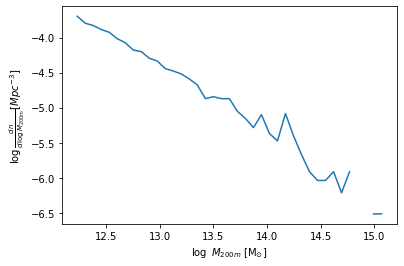

In [4]:
from scipy import stats

file_loc = '../simulations/L100N256_DMONLY/output/halo_catalogue/haloes_0003.VELOCIraptor.properties'
#get some information about the simulation (doesn't matter which snapshot for this section)
data = sw.load("../simulations/L100N256_DMONLY/output/snapshots/snap_0000.hdf5") #read first snapshot

#halo type
halo_type = veloc_reader(file_loc,'Structuretype')
cut = halo_type==10 #discount all subhaloes, only look at centrals

#get some information about the simulation
L = data.metadata.boxsize[0]
m_p = np.array(data.dark_matter.masses)[0]*10**10 #convert to M_sun
N_min = 200

#load halo masses from velociraptor cataogue
M_200m = veloc_reader(file_loc,'Mass_200mean') #in units of 10^10 M_sun
M_200m*=10**10 #convert to M_sun
M_200m=M_200m[cut] #select centrals

#set up bins
n_bins = 40
bins = np.linspace(np.log10(m_p*N_min),np.log10(np.max(M_200m)),n_bins)
#bin and count
count, bin_edged,_ = stats.binned_statistic(np.log10(M_200m), np.ones(len(M_200m)), 'count', bins=bins)

#calcaulte the middle of the bins
M_plot = bins[0:-1]+(bins[1]-bins[0])/2

#normalise counts by volume
count/= L**3

plt.figure()
plt.plot(M_plot,np.log10(count))
plt.ylabel('$\\log \\frac{dn}{d \\log M_{200m}} [Mpc^{-3}]$')
plt.xlabel('$\\log$ $M_{200m}$ [M$_{\\odot}$]')


<a id='dens_prof'></a>

## Density profiles

The distribution of mass within a DM halo is a key statistic that can be predicted by cosmological simulations. WIth the predictions of the simulation being able to be compared to observations that probe distribution of masses in galaxies and clusters (e.g. rotation curves, strong/weak lensing, etc). As DM haloes are roughly spherical the mass distribution can be approximated using the spherically averaged density profile, which is often presented in the literature.

In the following code we will calculate the density profile for the largest halo in the box. We first use the [VELOCIraptor](https://velociraptor-stf.readthedocs.io/en/latest/) halo catalogues to get the halo centre and size, then use [swiftsim_io](https://swiftsimio.readthedocs.io/en/latest/) to load only the particles near the halo. We then calculate the radii of the particles which are binned and the density calculated.

Here are a few ideas of things to explore:
- Fit an NFW profile. Where $\rho (r) = \frac{\rho_0}{(r/r_s)(1+r/r_s)^2}$, where you need to fit for $\rho_0$ and $r_s$. It is common to quote the concentration, $c\equiv R_{200c}/r_s$.
- calculate the mass-concentration relation. Fit individual haloes with NFW profiles, and plot $M_{200c}-c$ as a scatter plot.
- What is the effect of baryons
- What is the effect of resolution? (box size is trickier as the haloes won't be the same).

here
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.


Text(0, 0.5, '$\\rho$')

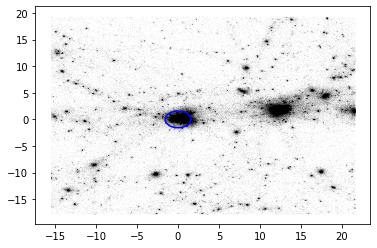

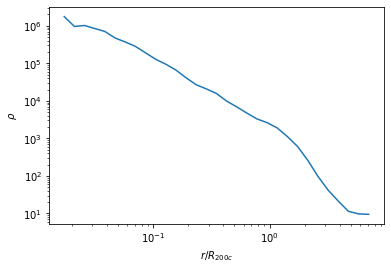

In [5]:
import swiftsimio as sw
import unyt 
from scipy import stats
snapshot_loc = "../simulations/L100N256_DMONLY/output/snapshots/snap_0003.hdf5"
file_loc = '../simulations/L100N256_DMONLY/output/halo_catalogue/haloes_0003.VELOCIraptor.properties'

G = 4.30 *10**-9 #gravitational constant, in units of Mpc /Msun *(km/s)^2

#get halo positions
x_pos = veloc_reader(file_loc,'Xcminpot')
y_pos = veloc_reader(file_loc,'Ycminpot')
z_pos = veloc_reader(file_loc,'Zcminpot')

pos = np.empty((len(x_pos),3))
pos[:,0] = x_pos; pos[:,1] = y_pos; pos[:,2] = z_pos;

#get halo M200c and R200c
halo_id = veloc_reader(file_loc,'ID')
M200c = veloc_reader(file_loc,'Mass_200crit')
R200c = veloc_reader(file_loc,'R_200crit')

#sort by halo_id
sort = np.argsort(halo_id)
M200c = M200c[sort]; R200c = R200c[sort]; halo_id = halo_id[sort]

#look at most massive
halo_num = 0

def density(halo_pos, bins, snapshot_loc, return_part_pos =False):
    #####################################
    # - halo_pos: centre of halo to calcuate dnesity profile for
    # - bins: the radial bins to use to calucalte density profile
    # - snapshot_loc: the lostaio of the snaphsot file
    # - return_part_pos: flag, whethere to return particl psoitons or just density profile
    #####################################
    
    #maximum radius needed
    R_max = np.max(bins)
    
    #use swift masking to only load needed particles, reduces computational cost
    mask = sw.mask(snapshot_loc)
    load_region = [[(halo_pos[i]-R_max)*unyt.Mpc,(halo_pos[i]+R_max)*unyt.Mpc] for i in range(len(halo_pos))] #add unyt data by *unyt.Mpc
    mask.constrain_spatial(load_region)
    
    #load simulation data with spatial mask
    data = sw.load(snapshot_loc, mask=mask)

    #calculate radii of particles
    part_pos = data.dark_matter.coordinates-np.repeat(halo_pos.reshape(1,-1),len(data.dark_matter.coordinates),axis=0)*unyt.Mpc
    for i in range(len(data.metadata.boxsize)): 
        part_pos[:,i] += -data.metadata.boxsize[i]*np.trunc(2*part_pos[:,i]/data.metadata.boxsize[i]) #deal with periodic boundary conditiond
    rad = np.sum(part_pos**2,axis=1)**0.5 
    
    #bin data and count mass
    mass_bin,bins_edge,_ = stats.binned_statistic(rad, data.dark_matter.masses, np.sum, bins=bins)

    #calculate centre of the bin and volume
    vol = 4/3*np.pi*(bins[1:]**3-bins[0:-1]**3)
    r_bin = 10**(0.5*(np.log10(bins[0:-1])+np.log10(bins[1:]))) #take mean of log r

    #calcualte density
    dens = mass_bin/vol
    
    if return_part_pos==True:
        return(r_bin,dens,part_pos)
    else:
        return(r_bin,dens)


bins = np.logspace(np.log10(0.01*R200c[halo_num]),np.log10(5*R200c[halo_num]),32)
print('here')
r_bin, rho, part_pos = density(pos[halo_num], bins, snapshot_loc, return_part_pos = True)

plt.figure()
plt.plot(part_pos[:,0],part_pos[:,1],'k.',markersize=0.05,alpha=0.2)
theta = np.linspace(0,2*np.pi)
plt.plot(R200c[halo_num]*np.cos(theta),R200c[halo_num]*np.sin(theta),'b-')
         
plt.figure()
plt.plot(r_bin, rho)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r/R_{200c}$')
plt.ylabel('$\\rho$')

